In [967]:
# Se der erro é so importar de novo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb
import scikitplot as skplt
from imblearn.combine import SMOTETomek

from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [968]:
df = pd.read_csv('describe.csv', index_col = 'Unnamed: 0')

## Dummies

In [969]:
df = pd.get_dummies(df, drop_first=True)

# knn imputer

In [970]:
from sklearn.impute import KNNImputer
num_feat = df.dtypes[df.dtypes.values != 'O'].index
imputer = KNNImputer(n_neighbors=10)

df[num_feat] = imputer.fit_transform(df[num_feat])

## Train test split e balanceamento

In [971]:
colunas = df.drop('CLASS_FINAL',1).columns

In [972]:
X = df.drop('CLASS_FINAL',1)
y = df['CLASS_FINAL']

Xres, X_test, yres, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sampling_strategy = 0.9
ru = SMOTETomek(sampling_strategy=sampling_strategy)
Xres, yres = ru.fit_sample(Xres, yres)

## Scaler

In [973]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 

scaler = MinMaxScaler()
scaler.fit(Xres)
Xres = pd.DataFrame(scaler.transform(Xres), columns = colunas)
X_test = pd.DataFrame(scaler.transform(X_test), columns = colunas)

In [974]:
pickle.dump(scaler, open("scaler.dat", "wb"))

In [975]:
Xres.shape

(2695, 45)

In [976]:
yres.shape

(2695,)

In [977]:
def roc(y_test,prob):
    prob = prob[:,1]
    return roc_auc_score(y_test, prob)

## Roc x K

In [978]:
roc_list = []
k = []
for i in range(1,46):
    kbest = SelectKBest(chi2, k=i)
    kbest.fit(Xres, yres)
    mask = kbest.get_support()
    xnew = kbest.transform(Xres)
    Xk = pd.DataFrame(xnew, columns=Xres.loc[:,mask].columns)
    X_test_k = X_test[Xk.columns]
    clf = xgb.XGBClassifier(n_estimators = 300)

    clf.fit(Xk, yres)
    clf_prob = clf.predict_proba(X_test_k)
    roc_list.append(roc(y_test, clf_prob))
    k.append(i)

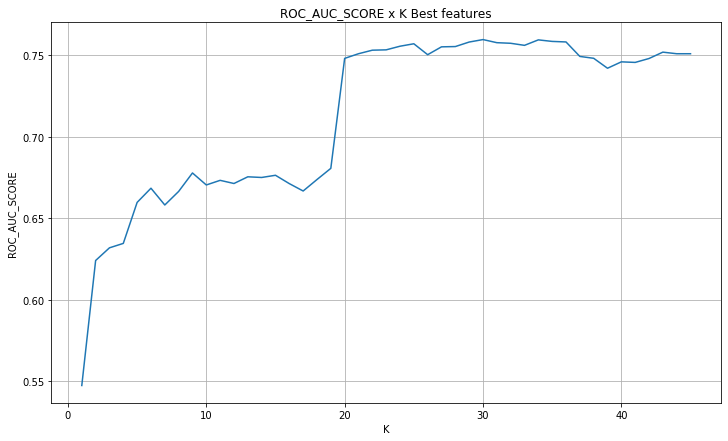

In [979]:
plt.figure(figsize=(12,7))
plt.plot(k,roc_list)
plt.xlabel('K')
plt.ylabel('ROC_AUC_SCORE')
plt.title('ROC_AUC_SCORE x K Best features')
plt.grid()

In [980]:
kbest = SelectKBest(chi2, k=21)
kbest.fit(Xres, yres)
mask = kbest.get_support()
xnew = kbest.transform(Xres)
Xk = pd.DataFrame(xnew, columns=Xres.loc[:,mask].columns)

Xk.columns

Index(['IS_PROFISSIONAL_SAUDE', 'SINT_FEBRE', 'SINT_TOSSE', 'SINT_CONG_NAZ',
       'SINT_CORIZA', 'SINT_GARGANTA', 'SINT_NAUZ', 'SINT_CEFALEIA',
       'SINT_ADINAMIA', 'SINT_EXSUDATO', 'VIAGEM_INTERNACIONAL',
       'COMORB_CARDIO', 'COMORB_DIABE', 'COMORB_IMUN',
       'COMORB_CIRURGIA_BARIAT', 'COMORB_OBESIDADE', 'COMORB_NEOPLASIAS',
       'COMORB_NEURO_CRONICA', 'SINT_DISPNEIA', 'SINT_MIALGIA',
       'CS_SEXO_Masculino'],
      dtype='object')